In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import sklearn.decomposition
import mdtraj
import random
from ensemble_analysis_lib import EnsembleAnalysis  # featurize, fit_dimensionality_reduction, transform

# 0- Load and process the data

### t-SNE parameters:
PerplexityVals: this parameter completely described here https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html. Determining the best cluster is based on Silhouette score, this score is computed iteratively for the different perplexity values and number of clusters. Different number of clusters can be tried during the k-means clustering part. Selecting a range of Perplexity Values is based on the number of data points you have. It should not be exceeded the number of data points. "metric" parameter is explained here https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html but I found out for symmetrical matrices we can change it to 'precomputed'. dir is the folder that the data related to tsne are going to be saved there. 

### PCA parameters:
num dim: Number of components to keep. if n_components(num dim) is not set all components are kept. more information are here: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

### DimenFix:
This is a method which is working based on Force Scheme technique to reduce the dimension of data. Complementory information could be find here: https://pure.tue.nl/ws/portalfiles/portal/297458194/2211.16752.pdf



### Featurization options:
ca-dist, phi-psi and a-angel: Internal features of the ensemble that you can choose. ca_dist provides the distance between all pairs of CA atoms. On the other hand phi-psi and a-angle provide phis-psi and alpha angel matrices whithin the ensmeble.  

In [2]:
# Codes of the ensembles we want to analyze. In this notebook, they are the
# same of the prefixes of the corresponding PDB files.
ens_codes = [


    "combined_1",  
    "combined_5",
    "combined_10",  
    # "combined_15",
    # "combined_20",  
    # "combined_25",
    # "combined_30",  
    # "combined_35",
    # "combined_40",  
    # "combined_45",
   
    # "PED00160",
    # "PED00161",
    "PED00423",
    "PED00424",
    # "PED00487", 
]
# Directory with the PDB files.
pdb_dp = "/home/hamid/PED_Data_analysis/giacomo_codes/PDBs/combined_renumbered/"

# Featurization options.
featurization = "phi_psi"  # choices: "ca_dist", "phi_psi"
featurization_params = {"ca_dist": {"seq_sep": 2, "normalize": True},
                        "phi_psi": {},
                        "a_angle": {}}


# Dimensionality reduction options. 'tsne' or 'pca' or 'dimenfix'
reduce_dim_method = "tsne"
reduce_dim_params = {"pca": {"num_dim": None}, "tsne": {"perplexityVals": range(500,1001,500), 'metric' : 'euclidean',   'dir' :'/home/hamid/PED_Data_analysis/random_ensemble/'}, "dimenfix": {}}

### 1- Making your EnsembleAnalysis object
- pdb_dp is the directory which contains the ensembles  <br>
- ens_codes is the basename's list of the multi model pdb files of each ensemble 

In [3]:
pipeline = EnsembleAnalysis(pdb_dp=pdb_dp,
                            ens_codes=ens_codes)


# Loading /home/hamid/PED_Data_analysis/giacomo_codes/PDBs/combined_renumbered/combined_1.dcd.
- Found 1000 conformations.
# Loading /home/hamid/PED_Data_analysis/giacomo_codes/PDBs/combined_renumbered/combined_5.dcd.
- Found 1000 conformations.
# Loading /home/hamid/PED_Data_analysis/giacomo_codes/PDBs/combined_renumbered/combined_10.dcd.
- Found 1000 conformations.
# Loading /home/hamid/PED_Data_analysis/giacomo_codes/PDBs/combined_renumbered/PED00423.dcd.
- Found 1000 conformations.
# Loading /home/hamid/PED_Data_analysis/giacomo_codes/PDBs/combined_renumbered/PED00424.dcd.
- Found 1000 conformations.


### 2- Extract your desired feature from the ensembles' trajcetories

- featurization is the selected feature (phi-psi or ca_dist)
- featurization_params is the parameters related to each selected feature 

In [4]:
pipeline.featurize(featurization=featurization,
                   featurization_params=featurization_params[featurization])



# Featurizing the combined_1 ensemble.
- Featurized ensemble shape: (1000, 182)
# Featurizing the combined_5 ensemble.
- Featurized ensemble shape: (1000, 182)
# Featurizing the combined_10 ensemble.
- Featurized ensemble shape: (1000, 182)
# Featurizing the PED00423 ensemble.
- Featurized ensemble shape: (1000, 182)
# Featurizing the PED00424 ensemble.
- Featurized ensemble shape: (1000, 182)
Concatenated featurized ensemble shape: (5000, 182)


## 2-1 Concat_features 
- is saving the matrix of concatanated selected feature for all the ensemble you want to analyze as numpy.ndarray

In [5]:
concat_feature_phi_psi = pipeline.concat_features
concat_feature_phi_psi.shape

(5000, 182)

## 2-2 Concat_features 
- making a list of all Rg values for the all conformations under studied

In [6]:
rg = pipeline.rg_calculator()


In [7]:
len(rg)

5000

## 3- Fit dimensionality reduction
- Apply the selected dimensionality reduction method on the selected feature 

In [34]:
pipeline.fit_dimensionality_reduction(
    reduce_dim_method=reduce_dim_method, reduce_dim_params= reduce_dim_params[reduce_dim_method])


tsne is your selected dimensionality reduction method!
tsne is running...
tsne file for the perplexity value of 500 is saved in /home/hamid/PED_Data_analysis/random_ensemble/ 
tsne file for the perplexity value of 1000 is saved in /home/hamid/PED_Data_analysis/random_ensemble/ 
tsne is done! All files saved in /home/hamid/PED_Data_analysis/random_ensemble/


#  4- Dimensionality reduction Analysis & Visulization

## 4-1 : **t-SNE**
 ## Run the next cell only if you select **tsne** as your selected dimensionality reduction method!

- Trying different number of clusters and different perplexity values to find the optimim silhouette score
- All the results are going to be saved in a directory determined in the step zero

In [9]:
# Specific to T-SNE
if reduce_dim_method == "tsne":
    from sklearn import metrics
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    range_n_clusters = range(2,10,1) # different range of n_cluster is added here
    perplexityVals = reduce_dim_params['tsne']['perplexityVals']
    for perp in perplexityVals:
        tsne = np.loadtxt(reduce_dim_params['tsne']['dir'] + '/tsnep'+str(perp))
        for n_clusters in range_n_clusters:
        # print("n_clusters",n_clusters)
            kmeans = KMeans(n_clusters=n_clusters, n_init= 'auto').fit(tsne)
            np.savetxt(reduce_dim_params['tsne']['dir'] + '/kmeans_'+str(n_clusters)+'clusters_centers_tsnep'+str(perp), kmeans.cluster_centers_, fmt='%1.3f')
            np.savetxt(reduce_dim_params['tsne']['dir'] + '/kmeans_'+str(n_clusters)+'clusters_tsnep'+str(perp)+'.dat', kmeans.labels_, fmt='%1.1d')
            
        # print("Kmeans",kmeans,kmeans.labels_)
#### Compute silhouette score based on low-dim and high-dim distances        
            silhouette_ld = silhouette_score(tsne, kmeans.labels_)
            silhouette_hd = metrics.silhouette_score(concat_feature_phi_psi, kmeans.labels_)
        # print(silhouette_ld)
            with open(reduce_dim_params['tsne']['dir']  + '/silhouette.txt', 'a') as f:
                f.write("\n")
                print(perp, n_clusters, silhouette_ld, silhouette_hd, silhouette_ld*silhouette_hd, file =f)
else:
    print("Check your reduced dimensionality method")

### Visulization of t-sne results

[1000.0, 2.0]
[   5    6    8 ... 4951 4958 4977] 0
[   0    1    2 ... 4997 4998 4999] 1


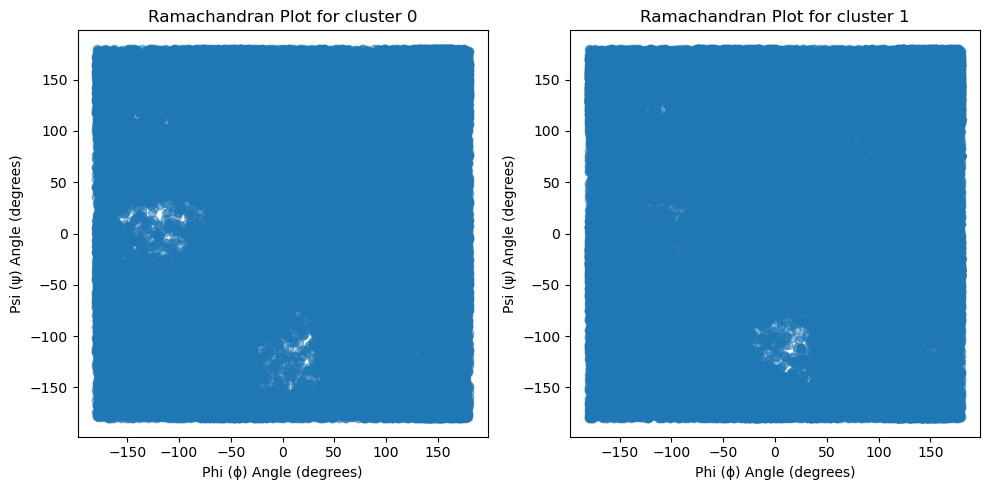

In [24]:
s = np.loadtxt(reduce_dim_params['tsne']['dir']  +'/silhouette.txt')
[bestP,bestK] = s[np.argmax(s[:,4]), 0], s[np.argmax(s[:,4]), 1]
print([bestP,bestK])
besttsne = np.loadtxt(reduce_dim_params['tsne']['dir']  + '/tsnep'+str(int(bestP)))
best_kmeans = KMeans(n_clusters=int(bestK), n_init='auto').fit(besttsne)
fig,axes = plt.subplots(1, 2, figsize = (10,5))

for cluster_id, ax in zip(range(int(bestK)),axes.ravel()):
    cluster_frames = np.where(best_kmeans.labels_ == cluster_id)[0]
    print(cluster_frames, cluster_id)
    
    phi_psi_cluster_id = np.degrees(concat_feature_phi_psi[cluster_frames]).ravel()

    phi_flat = phi_psi_cluster_id[0::2]

    psi_flat = phi_psi_cluster_id[1::2]

    ax.scatter(phi_flat, psi_flat, alpha=0.5)

    ax.set_title(f'Ramachandran Plot for cluster {cluster_id}')
    ax.set_xlabel('Phi (ϕ) Angle (degrees)')
    ax.set_ylabel('Psi (ψ) Angle (degrees)')
    
plt.tight_layout()
plt.show()


[1000.0, 2.0]
[   0    1    2 ... 4997 4998 4999]
[   5    6    8 ... 4951 4958 4977]


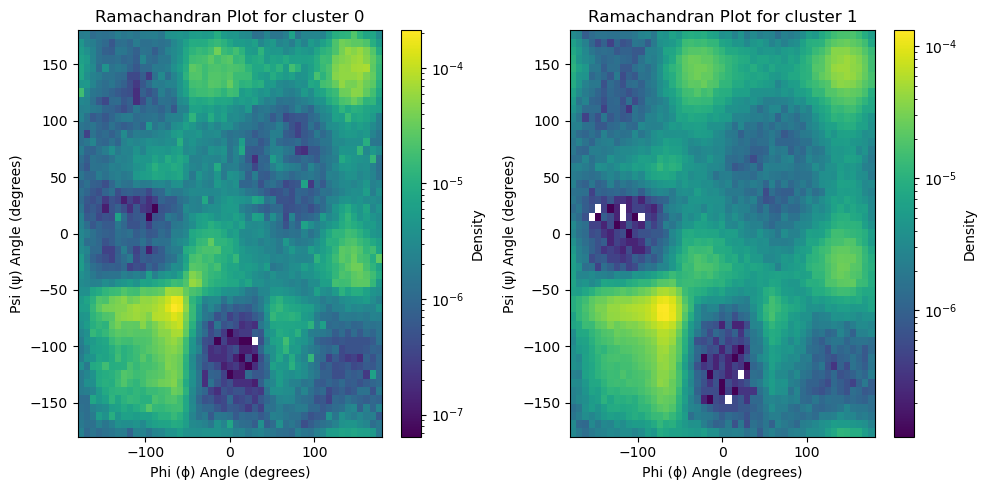

In [23]:
s = np.loadtxt(reduce_dim_params['tsne']['dir']  +'/silhouette.txt')
[bestP,bestK] = s[np.argmax(s[:,4]), 0], s[np.argmax(s[:,4]), 1]
print([bestP,bestK])
besttsne = np.loadtxt(reduce_dim_params['tsne']['dir']  + '/tsnep'+str(int(bestP)))
best_kmeans = KMeans(n_clusters=int(bestK), n_init='auto').fit(besttsne)
from matplotlib import colors
rama_bins = 50
rama_linspace = np.linspace(-180,180, rama_bins)
fig,axes = plt.subplots(1, 2, figsize = (10,5))

for cluster_id, ax in zip(range(int(bestK)),axes.flatten()):
    cluster_frames = np.where(best_kmeans.labels_ == cluster_id)[0]
    print(cluster_frames)
    
    phi_psi_cluster_id = np.degrees(pipeline.concat_features[cluster_frames]).flatten()
    phi_flat = phi_psi_cluster_id[0::2]

    psi_flat = phi_psi_cluster_id[1::2]
    hist = ax.hist2d(phi_flat, psi_flat, cmap="viridis", bins=(rama_linspace, rama_linspace),  norm=colors.LogNorm(),density=True  )
    cbar = fig.colorbar(hist[-1], ax=ax)

    cbar.set_label("Density")
    
    ax.set_title(f'Ramachandran Plot for cluster {cluster_id}')
    ax.set_xlabel('Phi (ϕ) Angle (degrees)')
    ax.set_ylabel('Psi (ψ) Angle (degrees)')
  
plt.tight_layout()
plt.show()


In [12]:
import seaborn as sns
from scipy.stats import gaussian_kde


1000.0 2.0


/tmp/ipykernel_2886941/4206195195.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', bestK)


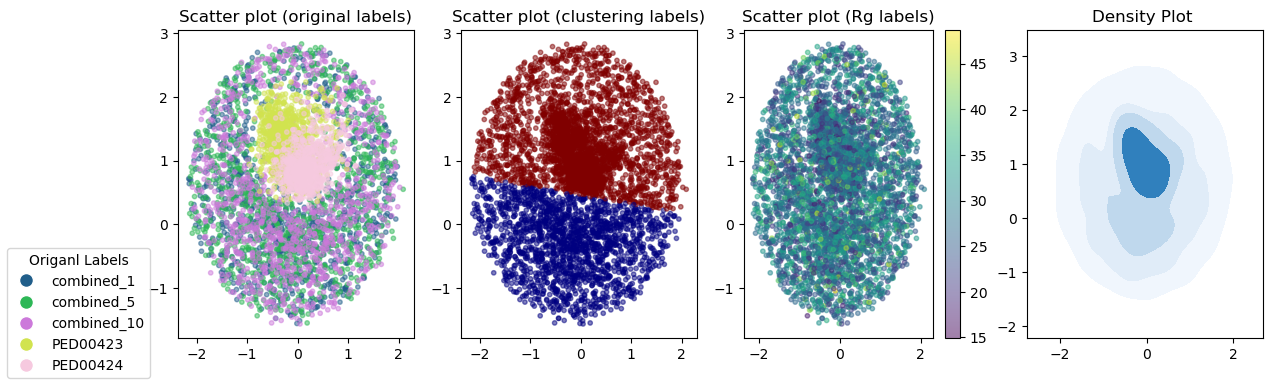

In [17]:
if reduce_dim_method == "tsne":
    fig , (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(14 ,4)) 
    import matplotlib.cm as cm
    s = np.loadtxt(reduce_dim_params['tsne']['dir']  +'/silhouette.txt')
    [bestP,bestK] = s[np.argmax(s[:,4]), 0], s[np.argmax(s[:,4]), 1]
    besttsne = np.loadtxt(reduce_dim_params['tsne']['dir']  + '/tsnep'+str(int(bestP)))
    bestclust = np.loadtxt(reduce_dim_params['tsne']['dir']  +'/kmeans_'+str(int(bestK))+'clusters_tsnep'+str(int(bestP))+'.dat')
    print(bestP, bestK)
   

    # scatter original  labels
    label_colors = {label: "#{:06x}".format(random.randint(0, 0xFFFFFF)) for label in ens_codes}
    point_colors = list(map(lambda label: label_colors[label], pipeline.all_labels))
    scatter_labeled = ax1.scatter(besttsne[:, 0], besttsne[:, 1], c=point_colors, s=10, alpha = 0.5)
    
    # scatter Rg labels 
    # Rg in Angstrom
    rg_labeled = ax3.scatter(besttsne[:, 0], besttsne[:, 1], c= [rg for rg in rg], s=10, alpha=0.5) 
    cbar = plt.colorbar(rg_labeled, ax=ax3)
    
    # scatter cluster labels
    cmap = cm.get_cmap('jet', bestK)
    scatter_cluster = ax2.scatter(besttsne[:,0], besttsne[:,1], c= bestclust.astype(float), s=10,cmap=cmap ,alpha=0.5)
    
    # manage legend
    legend_labels = list(label_colors.keys())
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_colors[label], markersize=10) for label in legend_labels]
    fig.legend(legend_handles, legend_labels, title='Origanl Labels', loc = 'lower left')

    # KDE plot
    sns.kdeplot(x=besttsne[:, 0], y=besttsne[:, 1], ax=ax4, fill=True, cmap='Blues', levels=5)

    # ax1.scatter(grid_positions[0, densest_indices], grid_positions[1, densest_indices], c='red', marker='x', s=50, label='Densest Points')
    ax1.set_title('Scatter plot (original labels)')
    ax2.set_title('Scatter plot (clustering labels)')
    ax3.set_title('Scatter plot (Rg labels)')
    ax4.set_title('Density Plot ')
    
    plt.savefig(reduce_dim_params['tsne']['dir']  +'/tsnep'+str(int(bestP))+'_kmeans'+str(int(bestK))+'.png', dpi=800)
else:
    print("Check your reduced dimensionality method")

In [156]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import random
import seaborn as sns
import matplotlib.cm as cm

# Replace the following lines with your actual data loading and processing
# besttsne, bestclust, point_colors, rg_values_list, ens_codes, pipeline.all_labels

# Add the 'Row' information to the data
row_numbers = np.arange(len(besttsne))
fig1 = px.scatter(x=besttsne[:, 0], y=besttsne[:, 1], color=[rg[0]*10 for rg in rg_values_list], labels={'color': 'Rg Labels'},
                  hover_data={'Row': row_numbers})
fig1.show()

NameError: name 'besttsne' is not defined

### DimenFix Analysis and Visualization

In [63]:
row = np.arange(len(pipeline_1.reduce_dim_model))
import plotly.graph_objects as go 
fig = go.Figure(data=
                go.Scatter(x=pipeline_1.reduce_dim_model[:, 0],
                            y=pipeline_1.reduce_dim_model[:, 1],
                            mode='markers',
                            
                            marker=dict(
                                size=16,
                                color= rg_numbers,
                                colorscale='Viridis',
                                showscale=True),
                                
                        )
                )
fig.show()

In [61]:
fig1 = px.scatter(x=pipeline_1.reduce_dim_model[:, 0], y=pipeline_1.reduce_dim_model[:, 1], color=pipeline_1.all_labels,
                  hover_data={'Row': row})

fig1.update_traces(marker=dict(size=6,
                              line=dict(width=2,
                                        )),
                  )
fig1.show()

In [82]:
y_threshold = 44.6 # Define your threshold here

# Create the scatter plot
fig1 = px.scatter(x=pipeline_1.reduce_dim_model[:, 0], y=pipeline_1.reduce_dim_model[:, 1])

# Find indices of points below the threshold
below_threshold_indices = np.where(((pipeline_1.reduce_dim_model[:, 1] > 15)  & (pipeline_1.reduce_dim_model[:, 1] < 50) 
                                    ) & ((pipeline_1.reduce_dim_model[:, 0] > 16) & (pipeline_1.reduce_dim_model[:, 0] < 38)))[0]

# Get the row numbers corresponding to these indices
row_numbers = below_threshold_indices.tolist()
row_numbers_filtered = [r for r in row_numbers if r <10000]


In [80]:
pipeline_1.trajectories

{'combined_1': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2ce56efd90>,
 'combined_5': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2e1c0f9f90>,
 'combined_10': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2e34bc0450>,
 'combined_15': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2ce519e850>,
 'combined_20': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2d332a42d0>,
 'combined_25': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2d332a4090>,
 'combined_30': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2ce6390250>,
 'combined_35': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2ce4fc0290>,
 'combined_40': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residu

In [85]:
len(row_numbers_filtered)

2733

In [83]:
for model_number in row_numbers_filtered:

    if model_number >= 0 and model_number < 1000:
        model_trajectory = pipeline_1.trajectories['combined_1'][model_number]
        output_filename = f'model_{model_number +  1}.pdb'
        model_trajectory.save_pdb(output_filename)
    elif model_number >= 1000 and model_number < 2000:
        model_trajectory = pipeline_1.trajectories['combined_5'][model_number-1000]
        output_filename = f'model_{model_number  +  1}.pdb'
        model_trajectory.save_pdb(output_filename)
    elif  model_number >= 2000 and model_number < 3000:
        model_trajectory = pipeline_1.trajectories['combined_10'][model_number-2000]
        output_filename = f'model_{model_number  +  1}.pdb'
        model_trajectory.save_pdb(output_filename)
    elif  model_number >= 3000 and model_number < 4000:
        model_trajectory = pipeline_1.trajectories['combined_15'][model_number-3000]
        output_filename = f'model_{model_number +  1}.pdb'
        model_trajectory.save_pdb(output_filename)
    elif  model_number >= 4000 and model_number < 5000:
        model_trajectory = pipeline_1.trajectories['combined_20'][model_number-4000]
        output_filename = f'model_{model_number  +  1}.pdb'
        model_trajectory.save_pdb(output_filename) 
    elif  model_number >= 5000 and model_number < 6000:
        model_trajectory = pipeline_1.trajectories['combined_25'][model_number-5000]
        output_filename = f'model_{model_number +  1}.pdb'
        model_trajectory.save_pdb(output_filename) 
    elif  model_number >= 6000 and model_number < 7000:
        model_trajectory = pipeline_1.trajectories['combined_30'][model_number-6000]
        output_filename = f'model_{model_number  +  1}.pdb'
        model_trajectory.save_pdb(output_filename)  
    elif  model_number >= 7000 and model_number < 8000:
        model_trajectory = pipeline_1.trajectories['combined_35'][model_number-7000]
        output_filename = f'model_{model_number  +  1}.pdb'
        model_trajectory.save_pdb(output_filename) 
    elif  model_number >= 8000 and model_number < 9000:
        model_trajectory = pipeline_1.trajectories['combined_40'][model_number-8000]
        output_filename = f'model_{model_number +  1}.pdb'
        model_trajectory.save_pdb(output_filename) 
    elif  model_number >= 9000 and model_number < 10000:
        model_trajectory = pipeline_1.trajectories['combined_20'][model_number-9000]
        output_filename = f'model_{model_number  +  1}.pdb'
        model_trajectory.save_pdb(output_filename)            

    

In [65]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
X = pipeline_1.reduce_dim_model  # For reproducibility
range_n_clusters = [2, 3, 4, 5, 6]
sil_scores = []
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sil_scores.append((n_clusters,silhouette_avg))
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters = 2 The average silhouette_score is : 0.3433121990322032
For n_clusters = 3 The average silhouette_score is : 0.38108939228600713
For n_clusters = 4 The average silhouette_score is : 0.39054749033768615
For n_clusters = 5 The average silhouette_score is : 0.36203065680934876
For n_clusters = 6 The average silhouette_score is : 0.38373418776397017


In [66]:
sil_scores

[(2, 0.3433121990322032),
 (3, 0.38108939228600713),
 (4, 0.39054749033768615),
 (5, 0.36203065680934876),
 (6, 0.38373418776397017)]

In [67]:
def s_max(s_list):
    s = 0
    for i in sil_scores:
        if i[1] > s:
            s = i[1]
            k = i[0]
    return k

/home/hamid/anaconda3/envs/ped/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



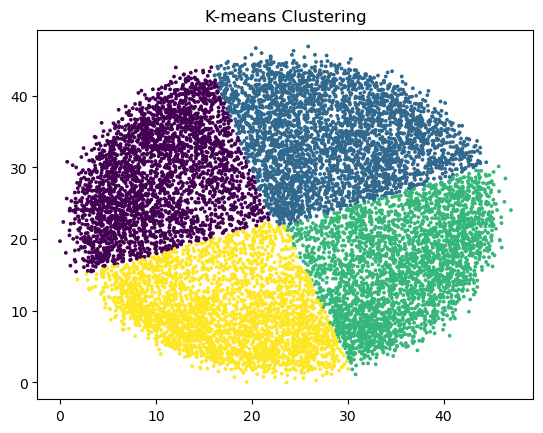

In [77]:
label_colors = {label: "#{:06x}".format(random.randint(0, 0xFFFFFF)) for label in ens_codes}
point_colors = list(map(lambda label: label_colors[label], pipeline_1.all_labels))

n_clusters = s_max(sil_scores)

# Apply K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(pipeline_1.reduce_dim_model)

# Plot the points with different colors for each cluster
plt.scatter(pipeline_1.reduce_dim_model[:, 0], pipeline_1.reduce_dim_model[:, 1], s=3 ,c=labels, cmap='viridis')
plt.title('K-means Clustering')
plt.show()

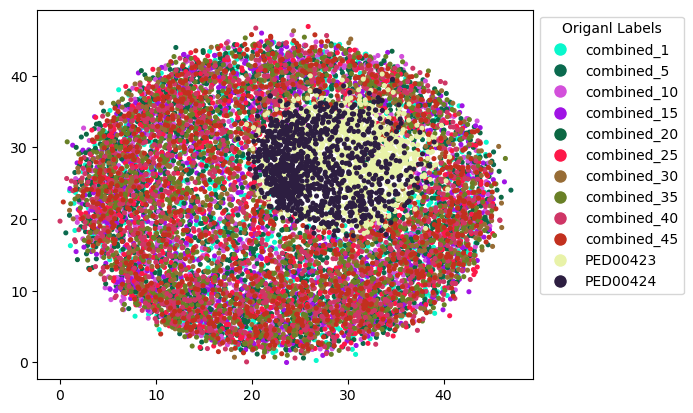

In [78]:
n_clusters = s_max(sil_scores)

# Apply K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = point_colors

# Plot the points with different colors for each cluster
plt.figure(dpi=100)
plt.scatter(pipeline_1.reduce_dim_model[:, 0], pipeline_1.reduce_dim_model[:, 1], c=labels, s=7)
# plt.title('K-means Clustering')
legend_labels = list(label_colors.keys())
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_colors[label], markersize=10) for label in legend_labels]
plt.legend(legend_handles, legend_labels, title='Origanl Labels', loc = 'upper left', bbox_to_anchor=(1, 1))
plt.show()

## PCA Analysis

- Percentage of variance explained by each of the selected components:


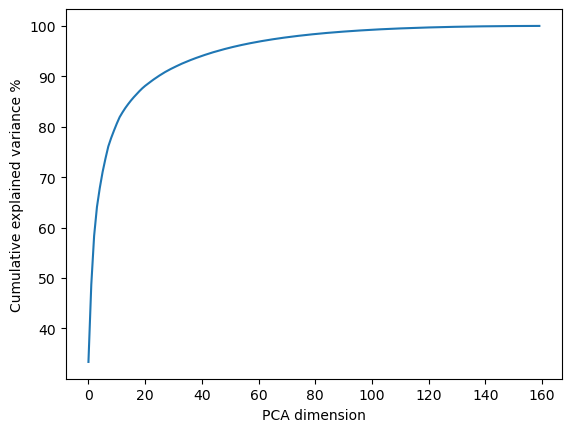

- First three: 58.36188793182373


In [10]:
# Specific to PCA. In my opinion, useful PCAs should have at least
# a total of > 50% in the first 3 components.
if reduce_dim_method == "pca":
    print("- Percentage of variance explained by each of the selected components:")
    plt.plot(np.cumsum(pipeline.reduce_dim_model.explained_variance_ratio_)*100)
    plt.xlabel("PCA dimension")
    plt.ylabel("Cumulative explained variance %")
    plt.show()
    print("- First three:", pipeline.reduce_dim_model.explained_variance_ratio_[0:3].sum()*100)

### Plot 2d landscapes

In [11]:
def set_labels(ax):
    ax.set_xlabel(f"{reduce_dim_method} dim {dim_x+1}")
    ax.set_ylabel(f"{reduce_dim_method} dim {dim_y+1}")

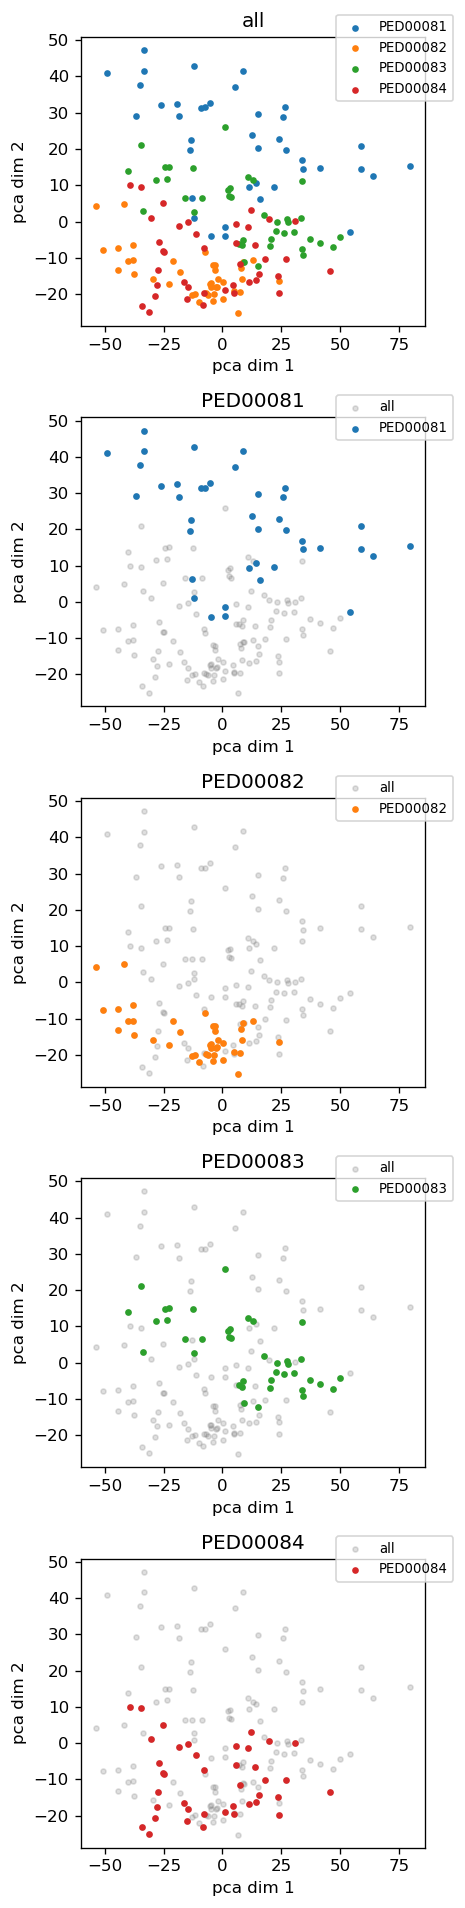

In [12]:
# 2d scatters.
dim_x = 0
dim_y = 1
marker = "."
legend_kwargs = {"loc": 'upper right',
                 "bbox_to_anchor": (1.1, 1.1),
                 "fontsize": 8}

# Plot all ensembles at the same time.
fig, ax = plt.subplots(len(ens_codes)+1, figsize=(4, 4*len(ens_codes)), dpi=120)
ax[0].set_title("all")
for code_i in pipeline.ens_codes:
    ax[0].scatter(pipeline.reduce_dim_data[code_i][:,dim_x],
                  pipeline.reduce_dim_data[code_i][:,dim_y],
                  label=code_i, marker=marker)
ax[0].legend(**legend_kwargs)
set_labels(ax[0])

# Plot each ensembles.
for i, code_i in enumerate(pipeline.ens_codes):
    ax[i+1].set_title(code_i)
    ax[i+1].scatter(pipeline.concat_reduce_dim_data[:,dim_x],
                    pipeline.concat_reduce_dim_data[:,dim_y],
                    label="all", color="gray", alpha=0.25,
                    marker=marker)
    ax[i+1].scatter(pipeline.reduce_dim_data[code_i][:,dim_x],
                    pipeline.reduce_dim_data[code_i][:,dim_y],
                    label=code_i, c=f"C{i}",
                    marker=marker)
    ax[i+1].legend(**legend_kwargs)
    set_labels(ax[i+1])

plt.tight_layout()
plt.savefig(reduce_dim_params['tsne']['dir'] + 'PCA' + featurization+ ens_codes[0])
plt.show()


### 1d histograms

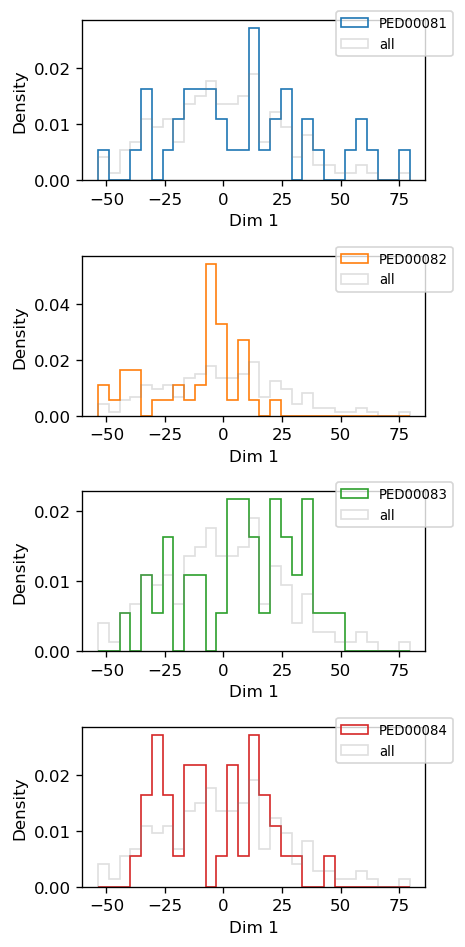

In [13]:
# 1d histograms. Looking at the scatter plot above can be misleading
# to the eye if we want to assess the density of points. Better use
# an histogram for a precise evaluation.
n_bins = 30

dpi = 120
fig, ax = plt.subplots(len(ens_codes), 1, figsize=(4, 2*len(ens_codes)), dpi=dpi)
k = 0
bins = np.linspace(pipeline.concat_reduce_dim_data[:,k].min(),
                   pipeline.concat_reduce_dim_data[:,k].max(),
                   n_bins)

for i, code_i in enumerate(ens_codes):
    ax[i].hist(pipeline.reduce_dim_data[code_i][:,k],
               label=code_i,
               bins=bins,
               density=True,
               color=f"C{i}",
               histtype="step")
    ax[i].hist(pipeline.concat_reduce_dim_data[:,k],
               label="all",
               bins=bins,
               density=True,
               color="gray",
               alpha=0.25,
               histtype="step")
    ax[i].legend(loc='upper right',
                 bbox_to_anchor=(1.1, 1.1),
                 fontsize=8
                )
    ax[i].set_xlabel(f"Dim {k+1}")
    ax[i].set_ylabel("Density")

plt.tight_layout()
plt.savefig(reduce_dim_params['tsne']['dir'] + 'PCA_hist' + featurization+ ens_codes[0])
plt.show()

# Analyze the correletion between input features and reduced features

In [14]:
from matplotlib import colors, cm

if not reduce_dim_method == "pca":
    raise ValueError("Can only perform the analysis when using PCA")

/tmp/ipykernel_1912559/1947023292.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("RdBu")  # RdBu, PiYG


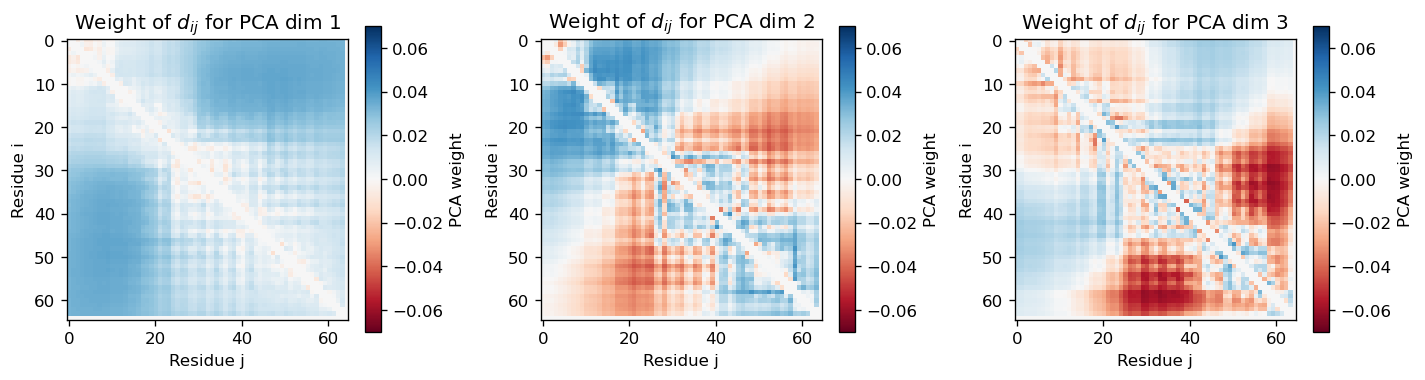

In [16]:
if featurization == "ca_dist":
    
    num_residues = 65# Number of residues in the protein.
    sel_dims = [0, 1, 2]  # Dimensionality reduction feature we want to analyze
    cmap = cm.get_cmap("RdBu")  # RdBu, PiYG
    norm = colors.Normalize(-0.07, 0.07)  # NOTE: this range should be adapted
                                          # when analyzing other systems via PCA!
    dpi = 120

    fig_r = 0.8
    fig, ax = plt.subplots(1, 3, dpi=dpi, figsize=(15*fig_r, 4*fig_r))

    for k, sel_dim in enumerate(sel_dims):
        feature_ids_sorted_by_weight = np.flip(np.argsort(abs(pipeline.reduce_dim_model.components_[sel_dim,:])))
        matrix = np.zeros((num_residues, num_residues))
        for i in feature_ids_sorted_by_weight:
            r1, r2 = pipeline.feature_names[i].split("-")
            # Note: this should be patched for proteins with resSeq values not starting from 1!
            matrix[int(r1[3:])-1, int(r2[3:])-1] = pipeline.reduce_dim_model.components_[sel_dim,i]
            matrix[int(r2[3:])-1, int(r1[3:])-1] = pipeline.reduce_dim_model.components_[sel_dim,i]
        im = ax[k].imshow(matrix, cmap=cmap, norm=norm)  # RdBu, PiYG
        ax[k].set_xlabel("Residue j")
        ax[k].set_ylabel("Residue i")
        ax[k].set_title(r"Weight of $d_{ij}$" + f" for PCA dim {sel_dim+1}")
        cbar = fig.colorbar(
            im, ax=ax[k],
            label="PCA weight"
        )
    plt.tight_layout()
    plt.show()

# Is PC 1 from Ca-Ca correlated with Rg? For fully intrinsically disordered proteins, this is what happens

An hallmark of fully-disordered ensembles at a global level is the following: when you do PCA with Ca-Ca distances, typically PC dimension 1 is strongly correlated with Rg, it describes changes in chain compactness. This is what happens in Sic1 ensembles too. 

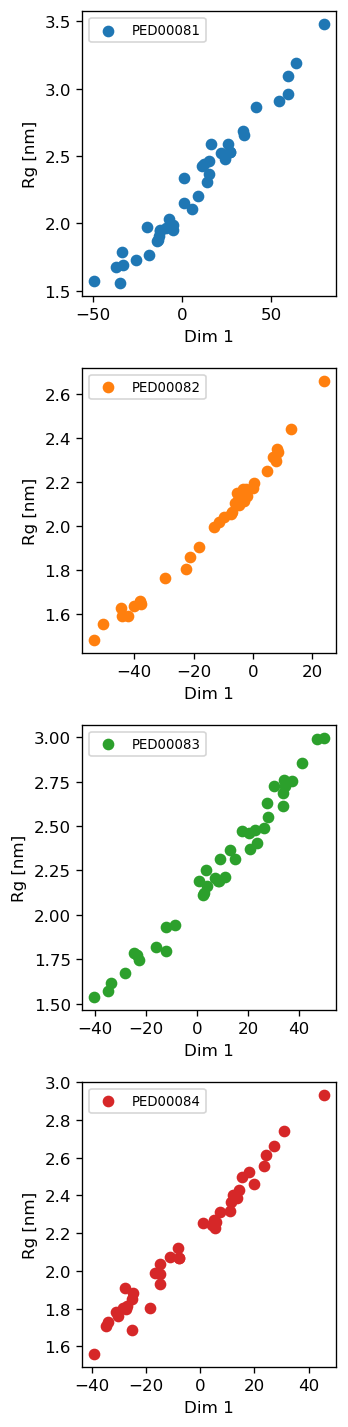

In [17]:
dpi = 120
fig, ax = plt.subplots(len(ens_codes), 1, figsize=(3, 3*len(ens_codes)), dpi=dpi)
pca_dim = 0

for i, code_i in enumerate(ens_codes):
    rg_i = mdtraj.compute_rg(pipeline.trajectories[code_i])
    ax[i].scatter(pipeline.reduce_dim_data[code_i][:,pca_dim],
               rg_i, label=code_i,
               color=f"C{i}"
    )
    ax[i].legend(fontsize=8)
    ax[i].set_xlabel(f"Dim {pca_dim+1}")
    ax[i].set_ylabel("Rg [nm]")

plt.tight_layout()
plt.savefig(reduce_dim_params['tsne']['dir'] + 'PCA_RG' + ens_codes[0])
plt.show()

In [88]:
from sklearn.manifold import MDS
embedding = MDS(n_components= 3)
feature_transformed = embedding.fit_transform(concat_feature)

/home/hamid/anaconda3/envs/ped/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



In [1]:

labels = point_colors
plt.figure(dpi=150)
z = feature_transformed[:, 2]
x = feature_transformed[:, 0]
y = feature_transformed[:, 1]

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(x, y, z, c= labels, alpha = 0.3)

# plt.title('K-means Clustering')
legend_labels = list(label_colors.keys())
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_colors[label], markersize=10) for label in legend_labels]
plt.legend(legend_handles, legend_labels, title='Origanl Labels', loc = 'upper left', bbox_to_anchor=(1, 1))
plt.show()

NameError: name 'point_colors' is not defined

In [18]:
from sklearn.manifold import MDS
embedding = MDS(n_components= 3)
feature_transformed = embedding.fit_transform(combined_feature)

/home/hamid/anaconda3/envs/ped/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


ValueError: Array must be symmetric

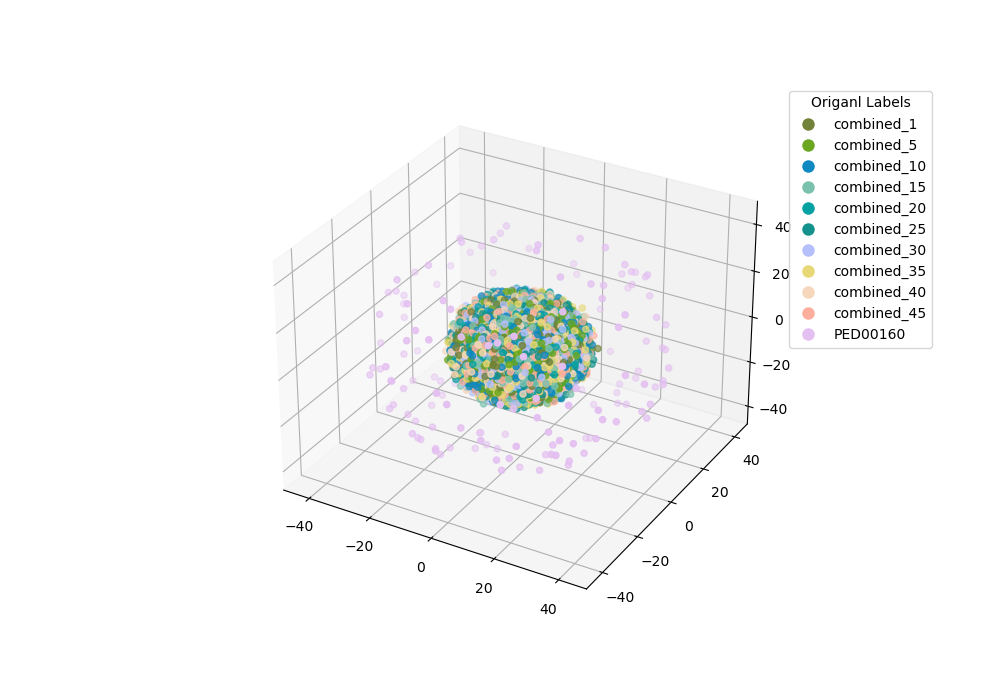

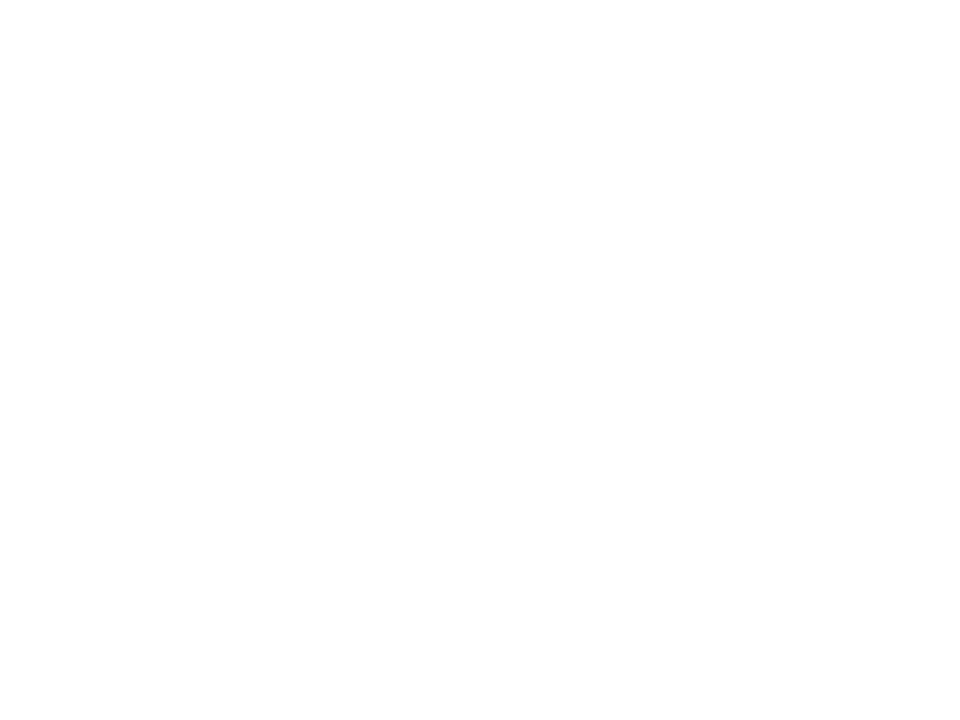

In [ ]:
labels = point_colors
plt.figure(dpi=150)
z = feature_transformed[:, 2]
x = feature_transformed[:, 0]
y = feature_transformed[:, 1]

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(x, y, z, c= labels)

# plt.title('K-means Clustering')
legend_labels = list(label_colors.keys())
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_colors[label], markersize=10) for label in legend_labels]
plt.legend(legend_handles, legend_labels, title='Origanl Labels', loc = 'upper left', bbox_to_anchor=(1, 1))
plt.show()

In [147]:
y_threshold = 20  # Define your threshold here

# Create the scatter plot
fig1 = px.scatter(x=pipeline.reduce_dim_model[:, 0], y=pipeline.reduce_dim_model[:, 1])

# Find indices of points below the threshold
below_threshold_indices = np.where(pipeline.reduce_dim_model[:, 1] < y_threshold)[0]

# Get the row numbers corresponding to these indices
row_numbers = below_threshold_indices.tolist()
model_numbers = [r-6000 for r in row_numbers]
non_filtered = [r for r in range(500) if r not in model_numbers]
len(non_filtered)


[0,
 3,
 6,
 7,
 8,
 9,
 11,
 12,
 13,
 15,
 16,
 17,
 19,
 20,
 22,
 23,
 24,
 26,
 28,
 29,
 31,
 32,
 34,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 45,
 48,
 49,
 51,
 52,
 53,
 54,
 55,
 56,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 69,
 70,
 74,
 75,
 76,
 77,
 78,
 79,
 82,
 83,
 84,
 85,
 86,
 87,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 102,
 103,
 104,
 106,
 108,
 109,
 110,
 111,
 112,
 114,
 115,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 129,
 131,
 133,
 134,
 136,
 137,
 139,
 140,
 141,
 145,
 146,
 147,
 148,
 149,
 151,
 152,
 153,
 154,
 156,
 157,
 158,
 159,
 160,
 161,
 164,
 165,
 166,
 167,
 168,
 170,
 171,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 198,
 201,
 202,
 204,
 205,
 208,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 218,
 219,
 220,
 221,
 225,
 227,
 228,
 231,
 233,
 234,
 235,
 237,
 239,
 240,
 244,
 246,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 25

In [233]:

trajectory = mdtraj.load('/home/hamid/PED_Data_analysis/giacomo_codes/PDBs/combined/PED00160.pdb')
trajectory

<mdtraj.Trajectory with 500 frames, 1374 atoms, 92 residues, without unitcells at 0x7fb0478db650>

In [234]:
trajectory = pipeline.trajectories
model_numbers = row_numbers_filtered
row_numbers_filtered

[0,
 4,
 13,
 14,
 15,
 18,
 19,
 22,
 26,
 27,
 34,
 40,
 42,
 44,
 49,
 54,
 55,
 58,
 60,
 61,
 64,
 68,
 69,
 71,
 76,
 89,
 91,
 96,
 102,
 107,
 108,
 117,
 118,
 121,
 125,
 127,
 129,
 140,
 142,
 150,
 157,
 164,
 167,
 172,
 177,
 178,
 179,
 181,
 182,
 183,
 190,
 191,
 192,
 193,
 196,
 204,
 207,
 219,
 221,
 227,
 228,
 236,
 237,
 243,
 256,
 265,
 268,
 279,
 284,
 291,
 294,
 298,
 302,
 304,
 305,
 306,
 307,
 309,
 313,
 314,
 318,
 321,
 323,
 326,
 328,
 331,
 334,
 336,
 341,
 342,
 344,
 345,
 348,
 355,
 356,
 359,
 368,
 371,
 375,
 376,
 380,
 384,
 385,
 391,
 392,
 393,
 401,
 402,
 403,
 405,
 406,
 407,
 409,
 422,
 427,
 441,
 443,
 446,
 450,
 454,
 455,
 456,
 459,
 463,
 465,
 470,
 477,
 479,
 483,
 487,
 488,
 491,
 492,
 496,
 498,
 499,
 501,
 502,
 503,
 506,
 508,
 520,
 534,
 536,
 538,
 540,
 548,
 549,
 552,
 555,
 556,
 558,
 561,
 563,
 564,
 569,
 570,
 576,
 577,
 578,
 586,
 587,
 588,
 590,
 591,
 592,
 595,
 597,
 599,
 600,
 601,
 606

In [79]:
pipeline_1.trajectories

{'combined_1': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2ce56efd90>,
 'combined_5': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2e1c0f9f90>,
 'combined_10': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2e34bc0450>,
 'combined_15': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2ce519e850>,
 'combined_20': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2d332a42d0>,
 'combined_25': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2d332a4090>,
 'combined_30': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2ce6390250>,
 'combined_35': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residues, without unitcells at 0x7f2ce4fc0290>,
 'combined_40': <mdtraj.Trajectory with 1000 frames, 1204 atoms, 92 residu

KeyError: 0